# Predicate-based classifiers

In [3]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC

# OHSUMED-BASED SCREENING DATASET
Predicate C04: Neoplasms <br>
Predicate C12: Urologic and Male Genital Diseases <br>
Predicate C10: Nervous System Diseases <br>
Predicate C14: Cardiovascular Diseases <br>
Predicate C23: Pathological Conditions, Signs and Symptoms

In [4]:
df1 = pd.read_csv('../data/ohsumed_data/ohsumed_C10_C23_1grams.csv')
df2 = pd.read_csv('../data/ohsumed_data/ohsumed_C14_C23_1grams.csv')
df3 = pd.read_csv('../data/ohsumed_data/ohsumed_C04_C12_1grams.csv')

## Linear SVM

In [46]:
seed = 123
k = 10

def get_data(predicate, df):
    X_pos = df.loc[df[predicate] == 1]['tokens'].values
    pos_num = len(X_pos)
#     X_neg = df.loc[df[predicate] == 0]['tokens'].values[:pos_num] # balanced data
    X_neg = df.loc[df[predicate] == 0]['tokens'].values # imbalanced data
    neg_num = len(X_neg)
    X = np.append(X_pos, X_neg)
    y = np.append(np.ones(pos_num), np.zeros(neg_num))    
    return X, y


pipeline  = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(class_weight='balanced', random_state=seed))
])

param_grid = {
    'vect__max_features': [2000],
    'vect__ngram_range': [(1, 1)],
    'clf__C': [0.01, 0.1, 1]
}

predicate_list = ['C10', 'C14', 'C23', 'C04', 'C12']
score_list = []
std_list = []

for predicate, df in zip(predicate_list, [df1, df2, df2, df3, df3]):
    X_train, y_train = get_data(predicate, df)
    grid = GridSearchCV(pipeline, cv=k, param_grid=param_grid, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)

    score_mean = grid.cv_results_['mean_test_score'][grid.best_index_]
    score_list.append(score_mean)
    score_std = grid.cv_results_['std_test_score'][grid.best_index_]
    std_list.append(score_std)

    print('{} best: {:1.3f} std: {:1.3f}, using {}'.format(predicate, score_mean, score_std, grid.best_params_))

C10 best: 0.539 std: 0.057, using {'clf__C': 0.01, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
C14 best: 0.782 std: 0.080, using {'clf__C': 0.1, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
C23 best: 0.523 std: 0.030, using {'clf__C': 0.1, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
C04 best: 0.777 std: 0.049, using {'clf__C': 0.01, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}
C12 best: 0.629 std: 0.085, using {'clf__C': 0.01, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1)}


## NNet (3 Layers with drop out)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

def get_data(predicate, df):
    X_pos = df.loc[df[predicate] == 1]['tokens'].values
    pos_num = len(X_pos)
#     X_neg = df.loc[df[predicate] == 0]['tokens'].values[:pos_num] # balanced data
    X_neg = df.loc[df[predicate] == 0]['tokens'].values # imbalanced data
    neg_num = len(X_neg)
    X = np.append(X_pos, X_neg)
    y = np.append(np.ones(pos_num), np.zeros(neg_num))
    return X, y


def create_model(optimizer='adagrad',
                     kernel_initializer='glorot_uniform',
                     dropout=0.2):
        model = Sequential()
        model.add(Dense(64, activation='relu', kernel_initializer=kernel_initializer))
        model.add(Dropout(dropout))
        model.add(Dense(32, activation='relu', kernel_initializer=kernel_initializer))
        model.add(Dropout(dropout))
        model.add(Dense(32, activation='relu', kernel_initializer=kernel_initializer))
        model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))

        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        return model
        
score_list2 = []
std_list2 = []
predicate_list = ['C10', 'C14', 'C23', 'C04', 'C12']
for predicate, df in zip(predicate_list, [df1, df2, df2, df3, df3]):
    X_, y_ = get_data(predicate, df)
    vectorizer = TfidfVectorizer(lowercase=False, max_features=2000, ngram_range=(1,1))
    X_ = vectorizer.fit_transform(X_).toarray()

    scaler = StandardScaler()
    clf = KerasRegressor(build_fn=create_model,  verbose=3, batch_size=64, epochs=15)
    pipeline = Pipeline([
        ('preprocess',scaler),
        ('clf', clf)
    ])

    k = 10
    skf = StratifiedKFold(n_splits=k, random_state=123)
    pre, rec, f1 = [], [], []
    for train_index, test_index in skf.split(X_, y_):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = y_[train_index], y_[test_index]

        model = pipeline.fit(X_train, y_train)
        y_prob = model.predict(X_test)
        y_classes = [1 if p >= 0.5 else 0 for p in y_prob]
        pre_, rec_, f1_, _ = precision_recall_fscore_support(y_test, y_classes, average='binary')
        pre.append(pre_)
        rec.append(rec_)
        f1.append(f1_)

    print('precision: {:1.2}, recall: {:1.2}, f1: {:1.2}'.format(np.mean(pre),
                                                                 np.mean(rec),
                                                                 np.mean(f1)))
    score_list2.append(np.mean(f1))
    std_list2.append(np.std(f1))


## Plot F1 score for predicate-based classifiers

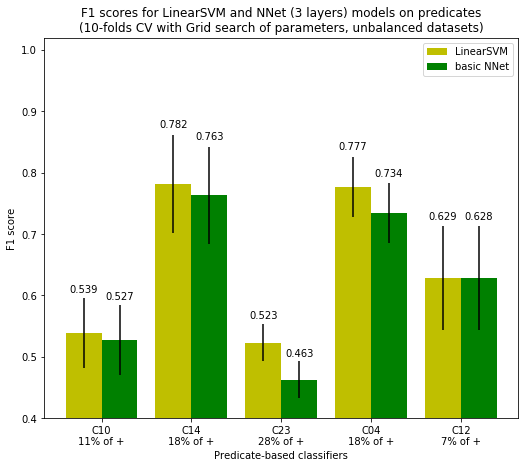

In [76]:
%matplotlib inline  
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8.5,7))
width = 0.4
ind = np.array(range(len(predicate_list)))
rects = ax.bar(ind, score_list, width, color='y', yerr=std_list)
rects2 = ax.bar(ind+width, score_list2, width, color='g', yerr=std_list)

ax.legend((rects[0], rects2[0]), ('LinearSVM', 'basic NNet'))
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('C10\n11% of +','C14\n18% of +','C23\n28% of +','C04\n18% of +','C12\n7% of +'))
ax.set_ylim((0.4, 1.02))
ax.set_ylabel('F1 score')
ax.set_xlabel('Predicate-based classifiers')
ax.set_title('F1 scores for LinearSVM and NNet (3 layers) models on predicates\n(10-folds CV with Grid search of parameters, unbalanced datasets)')


def autolabel(rects, values, errors):
    """
    Attach a text label above each bar displaying its height
    """
    for rect, val, e in zip(rects, values, errors):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*(height+e),
                '{:1.3f}'.format(val),
                ha='center', va='bottom')

autolabel(rects, score_list, std_list)
autolabel(rects2, score_list2, std_list)

plt.show()